## Offline Forecasting

This notebook contains the code examples from section 3.1.1 in Real-Time Machine Learning.

### Load the data sample

The data sample used in this notebook is a time series collection from OpenSky for a single aircraft over the course of an hour on June 27, 2022. We've included it in this repository to ensure reproducible results for the following code examples.

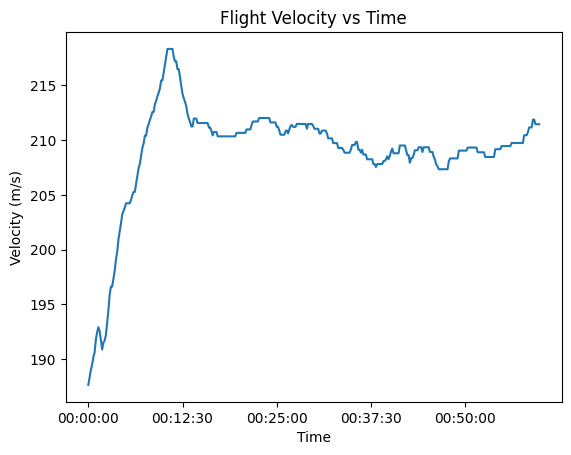

In [1]:
import os
import pandas as pd
import urllib.request
from matplotlib import pyplot as plt

# Load the data sample
file_path = 'data/opensky_sample_34718e.csv'
if not os.path.exists(file_path):
    url = "https://raw.githubusercontent.com/pdeziel/real-time-machine-learning/ch03/data/opensky_sample_34718e.csv"
    urllib.request.urlretrieve(url, file_path)

# Load the data from the CSV file
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['time'], unit='s')
df['hms'] = df['datetime'].dt.strftime('%H:%M:%S')

# Plot the flight velocity vs time
fig, ax = plt.subplots()
ax.set_title('Flight Velocity vs Time')
ax.set_xlabel('Time')
ax.set_ylabel('Velocity (m/s)')
ax.set_xticks(range(0, len(df), 75))
ax.plot(df['hms'], df['velocity'])

### Simple Linear Regression

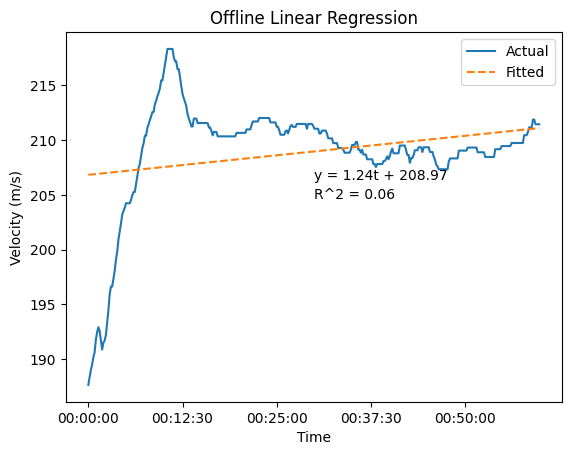

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
model = LinearRegression()
X = scaler.fit_transform(np.arange(len(df)).reshape(-1, 1))
y = df['velocity'].values
model.fit(X, y)
fig, ax = plt.subplots()
ax.set_title('Offline Linear Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Velocity (m/s)')
ax.set_xticks(range(0, len(df), 75))
ax.plot(df['hms'], df['velocity'], label='Actual')
ax.plot(df['hms'], model.predict(X), label='Fitted', linestyle='--')
ax.text(0.5, 0.6, f'y = {model.coef_[0]:.2f}t + {model.intercept_:.2f}', transform=ax.transAxes)
ax.text(0.5, 0.55, f'R^2 = {model.score(X, y):.2f}', transform=ax.transAxes)
ax.legend()

### Plot the moving average and variance over time

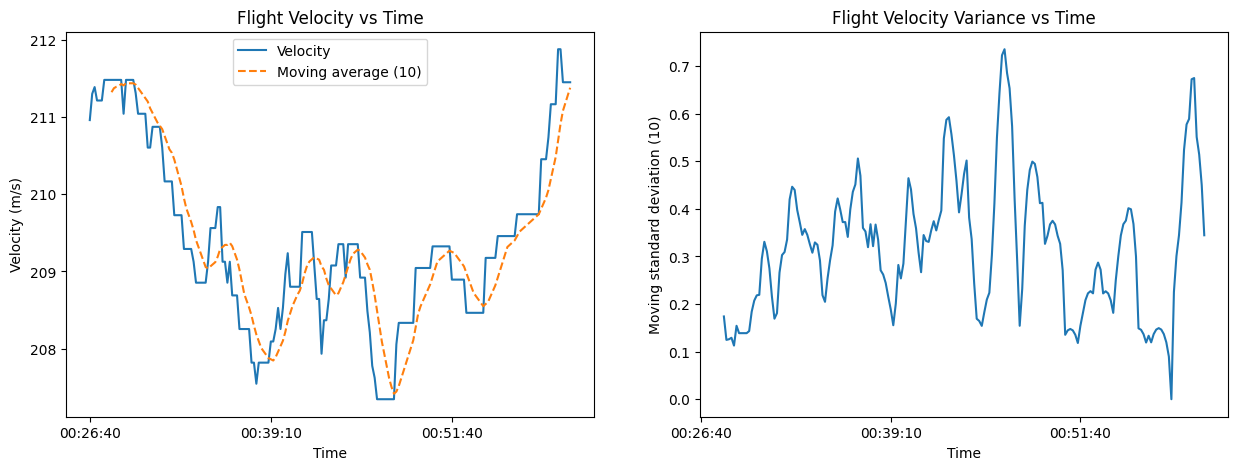

In [7]:
df = df[80:]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Flight Velocity vs Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Velocity (m/s)')
ax[0].set_xticks(range(0, len(df), 75))
ax[0].plot(df['hms'], df['velocity'], label='Velocity')
ax[0].plot(df['hms'], df['velocity'].rolling(10).mean(), label='Moving average (10)', linestyle='--')
ax[0].legend()
ax[1].set_title('Flight Velocity Variance vs Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Moving standard deviation (10)')
ax[1].set_xticks(range(0, len(df), 75))
ax[1].plot(df['hms'], df['velocity'].rolling(10).std())

### Test for stationarity in the data

In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['velocity'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.6f - The data is %s stationary with %s%% confidence' % (key, value, 'not' if result[0] > value else '', 100-int(key[:-1])))

ADF Statistic: -1.659318
p-value: 0.452186
Critical Values:
	1%: -3.454008 - The data is not stationary with 99% confidence
	5%: -2.871956 - The data is not stationary with 95% confidence
	10%: -2.572320 - The data is not stationary with 90% confidence


### Forecasting with Simple Exponential Smoothing and Holt-Winters

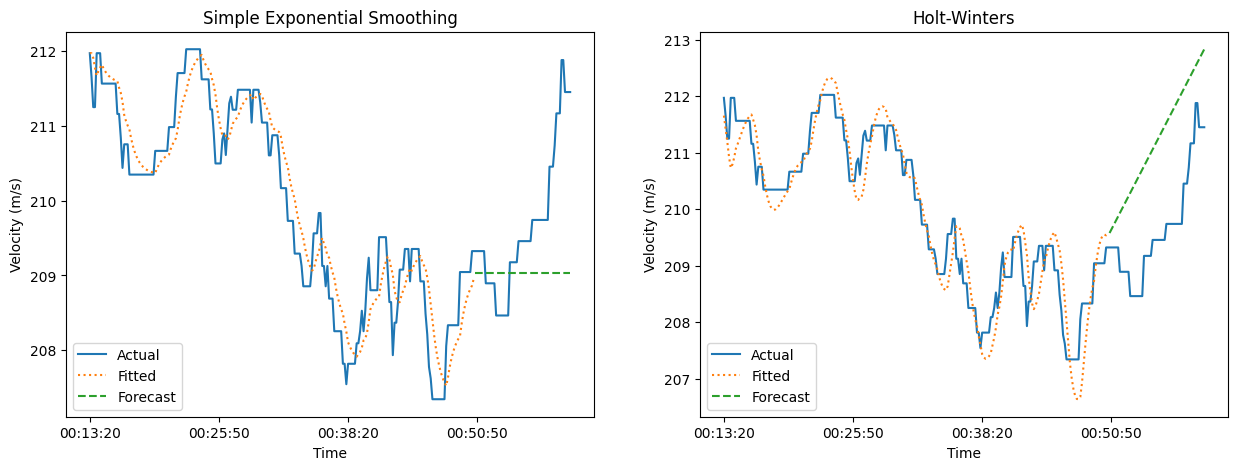

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

df = df.set_index('datetime').to_period('10s')
train_size = int(len(df) * 0.8)
train, test = df['velocity'][:train_size], df['velocity'][train_size:]
ses = SimpleExpSmoothing(train).fit(smoothing_level=0.2, optimized=False)
holt = Holt(train).fit(smoothing_level=0.2, smoothing_trend=0.3, optimized=False)
ses_pred = ses.forecast(len(test))
holt_pred = holt.forecast(len(test))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Simple Exponential Smoothing')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Velocity (m/s)')
ax[0].set_xticks(range(0, len(df), 75))
ax[0].plot(df['hms'], df['velocity'], label='Actual')
ax[0].plot(df['hms'][:train_size], ses.fittedvalues, label='Fitted', linestyle='dotted')
ax[0].plot(df['hms'][train_size:], ses_pred, label='Forecast', linestyle='dashed')
ax[0].legend()
ax[1].set_title('Holt-Winters')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity (m/s)')
ax[1].set_xticks(range(0, len(df), 75))
ax[1].plot(df['hms'], df['velocity'], label='Actual')
ax[1].plot(df['hms'][:train_size], holt.fittedvalues, label='Fitted', linestyle='dotted')
ax[1].plot(df['hms'][train_size:], holt_pred, label='Forecast', linestyle='dashed')
ax[1].legend()

### Plot rolling MAE for both forecasting methods

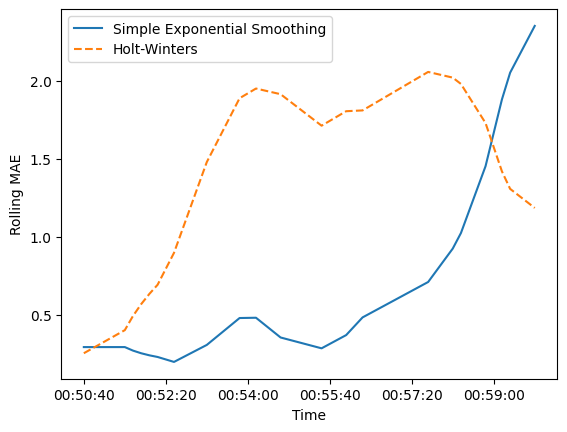

In [6]:
ses_errors = []
ses_mae = []
holt_errors = []
holt_mae = []
for i in range(len(test)):
    ses_errors.append(abs(test.iloc[i] - ses_pred.iloc[i]))
    ses_errors = ses_errors[-10:]
    ses_mae.append(sum(ses_errors) / len(ses_errors))
    holt_errors.append(abs(test.iloc[i] - holt_pred.iloc[i]))
    holt_errors = holt_errors[-10:]
    holt_mae.append(sum(holt_errors) / len(holt_errors))

fig, ax = plt.subplots()
ax.set_xlabel('Time')
ax.set_ylabel('Rolling MAE')
ax.set_xticks(range(0, len(test), 10))
ax.plot(df['hms'][train_size:], ses_mae, label='Simple Exponential Smoothing')
ax.plot(df['hms'][train_size:], holt_mae, label='Holt-Winters', linestyle='--')
ax.legend()